# Machine Learning: Prediction de l'hépatite C à partir de données sanguines

In [ ]:
#Chargement des packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
import time

In [2]:
#Chargements des données
dataset = pd.read_csv('C:\ml_project\hcvdat0.csv')
dataset.drop(columns=['Unnamed: 0'], inplace=True)
dataset.Sex = dataset.Sex.map({'m': 1, 'f':2})
dataset.Category = dataset.Category.map({'0=Blood Donor': 1, '1=Hepatitis': 0, '2=Fibrosis': 0, '3=Cirrhosis': 0, '0s=suspect Blood Donor': 0})

## Vue d'ensemble sur le dataset

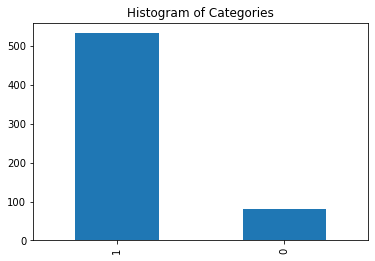

In [116]:
dataset['Category'].value_counts().plot(kind='bar', title = 'Histogram of Categories')

In [120]:
dataset.describe()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
count,615.000000,615.000000,615.000000,614.000000,597.000000,614.000000,615.000000,615.000000,615.000000,605.000000,615.000000,615.000000,614.000000
mean,0.866667,47.408130,1.386992,41.620195,68.283920,28.450814,34.786341,11.396748,8.196634,5.368099,81.287805,39.533171,72.044137
std,0.340211,10.055105,0.487458,5.780629,26.028315,25.469689,33.090690,19.673150,2.205657,1.132728,49.756166,54.661071,5.402636
min,0.000000,19.000000,1.000000,14.900000,11.300000,0.900000,10.600000,0.800000,1.420000,1.430000,8.000000,4.500000,44.800000
25%,1.000000,39.000000,1.000000,38.800000,52.500000,16.400000,21.600000,5.300000,6.935000,4.610000,67.000000,15.700000,69.300000
50%,1.000000,47.000000,1.000000,41.950000,66.200000,23.000000,25.900000,7.300000,8.260000,5.300000,77.000000,23.300000,72.200000
75%,1.000000,54.000000,2.000000,45.200000,80.100000,33.075000,32.900000,11.200000,9.590000,6.060000,88.000000,40.200000,75.400000
max,1.000000,77.000000,2.000000,82.200000,416.600000,325.300000,324.000000,254.000000,16.410000,9.670000,1079.100000,650.900000,90.000000


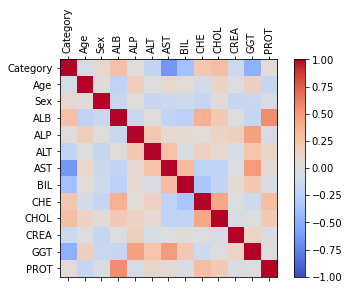

In [121]:
#Matrice de corrélation entre les variables
corr = dataset.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(dataset.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(dataset.columns)
ax.set_yticklabels(dataset.columns)
plt.show()

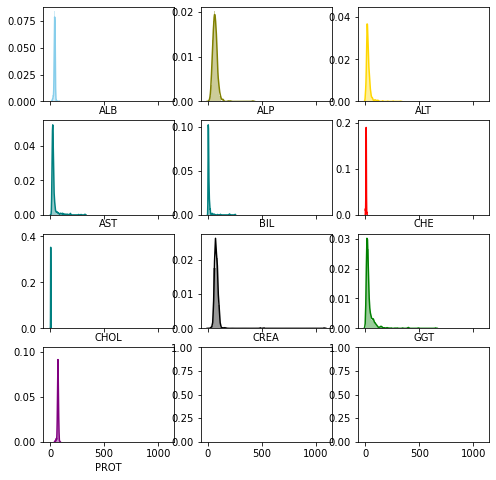

In [124]:
f, axes = plt.subplots(4, 3, figsize=(8, 8), sharex=True)
sns.distplot( dataset["ALB"] , color="skyblue", ax=axes[0, 0])
sns.distplot( dataset["ALP"] , color="olive", ax=axes[0, 1])
sns.distplot( dataset["ALT"] , color="gold", ax=axes[0, 2])
sns.distplot( dataset["AST"] , color="teal", ax=axes[1, 0])
sns.distplot( dataset["BIL"] , color="teal", ax=axes[1, 1])
sns.distplot( dataset["CHE"] , color="red", ax=axes[1, 2])
sns.distplot( dataset["CHOL"] , color="teal", ax=axes[2, 0])
sns.distplot( dataset["CREA"] , color="black", ax=axes[2, 1])
sns.distplot( dataset["GGT"] , color="green", ax=axes[2, 2])
sns.distplot( dataset["PROT"] , color="purple", ax=axes[3, 0])

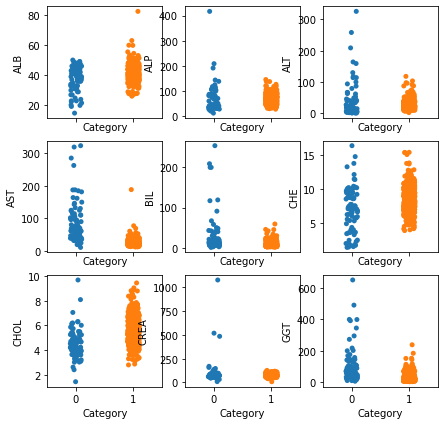

In [125]:
f, axes = plt.subplots(3, 3, figsize=(7, 7), sharex=True)
sns.stripplot(x="Category", y="ALB", data=dataset, ax=axes[0, 0])
sns.stripplot(x="Category", y="ALP", data=dataset, ax=axes[0, 1])
sns.stripplot(x="Category", y="ALT", data=dataset, ax=axes[0, 2])
sns.stripplot(x="Category", y="AST", data=dataset, ax=axes[1, 0])
sns.stripplot(x="Category", y="BIL", data=dataset, ax=axes[1, 1])
sns.stripplot(x="Category", y="CHE", data=dataset, ax=axes[1, 2])
sns.stripplot(x="Category", y="CHOL", data=dataset, ax=axes[2, 0])
sns.stripplot(x="Category", y="CREA", data=dataset, ax=axes[2, 1])
sns.stripplot(x="Category", y="GGT", data=dataset, ax=axes[2, 2])

## Preprocessing du dataSet

In [4]:
#Découpage des données par classe
blood_donor = dataset.iloc[:533, :].values
suspect_blood_donor = dataset.iloc[533:540, :].values
hepatitis = dataset.iloc[540:564, :].values
fibrosis = dataset.iloc[564:585, :].values
cirrhosis = dataset.iloc[585:, :].values

In [5]:
#Traitements des données manquantes
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")

In [6]:
imputer = imputer.fit(blood_donor[:,3:])
blood_donor[:,3:] = imputer.transform(blood_donor[:,3:])

imputer = imputer.fit(hepatitis[:,3:])
hepatitis[:,3:] = imputer.transform(hepatitis[:,3:])

imputer = imputer.fit(fibrosis[:,3:])
fibrosis[:,3:] = imputer.transform(fibrosis[:,3:])

imputer = imputer.fit(cirrhosis[:,3:])
cirrhosis[:,3:] = imputer.transform(cirrhosis[:,3:])


In [7]:
dataclean = np.concatenate((blood_donor, suspect_blood_donor, hepatitis, fibrosis, cirrhosis), axis=0)
#print (dataclean.head())

In [15]:
#**Extraction des donnees du fichier*#
###les variables explicatives    
X = dataclean[:, 1:]
###les classes
y = dataclean[:,0]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0, shuffle=True)

## Implémentation des 3 modèles choisois (Regression Logistique, KNN et SVM)

### 1) Modèle 1: KNN (made by Willy)

In [110]:
#standardiser les données d’entraînement et appliquer la même transformation aux données de test 
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


from sklearn.neighbors import KNeighborsClassifier
## Pour l'entrainement On fera varier k entre 1 et 99
maxa = 0
maxk=1
for k in range(1, 99):
 classifier = KNeighborsClassifier(n_neighbors = k)
 classifier.fit(X_train, y_train)
 y_pred = classifier.predict(X_test)
 result2 = accuracy_score(y_test,y_pred)
 #print("value of k is : {}  ".format(k) + "  " +"  Accuracy  ","   ::" , result2)
 if result2>maxa:
     maxa=result2
     maxk=k

In [111]:
classifier = KNeighborsClassifier(n_neighbors =maxk)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)
print("value of k is : {}".format(maxk))

Confusion Matrix:
[[ 11   5]
 [  0 107]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.69      0.81        16
         1.0       0.96      1.00      0.98       107

    accuracy                           0.96       123
   macro avg       0.98      0.84      0.90       123
weighted avg       0.96      0.96      0.96       123

Accuracy: 0.959349593495935
value of k is : 3


******Courbe ROC avant validation croisée


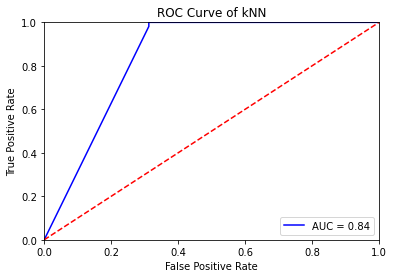

In [112]:
print("******Courbe ROC avant validation croisée")
knn = KNeighborsClassifier(n_neighbors = maxk)
knn.fit(X_train,y_train)
y_scores = knn.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()


In [113]:
print("*********************Validation des hyperparamétres avec GridSearchCV*********************")

param=[{"n_neighbors":list(range(1,15))}] 
knn= GridSearchCV(KNeighborsClassifier(), param,cv=5) 
data_knn=knn.fit(X_val, y_val)
# paramètre optimal 
data_knn.best_params_["n_neighbors"]
knn = KNeighborsClassifier(n_neighbors= data_knn.best_params_["n_neighbors"])
data_knn=knn.fit(X_train, y_train) 
# Estimation de l’erreur de prévision 
1-data_knn.score(X_test,y_test) 
# Prévision
y_chap = data_knn.predict(X_test)
result3 = confusion_matrix(y_test, y_chap)
result2 = classification_report(y_test, y_chap)
print (result2)
print (result3)


print("value of k is : {}".format(knn.n_neighbors))

*********************      Validation Croisée         *********************
              precision    recall  f1-score   support

         0.0       0.85      0.69      0.76        16
         1.0       0.95      0.98      0.97       107

    accuracy                           0.94       123
   macro avg       0.90      0.83      0.86       123
weighted avg       0.94      0.94      0.94       123

[[ 11   5]
 [  2 105]]
value of k is : 2


### 2) Regression Logistique (made by Fabius)

In [94]:
#Import des bibliothèques nécessaires
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc

#Apprentissage du modèle
classifier = LogisticRegression(random_state = 0, solver = 'liblinear')
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [95]:
#Test du modèle AVEC MATRICE DE CONFUSION
y_pred = classifier.predict(X_test)
score = classifier.score(X_test, y_test)
cm = confusion_matrix(y_test, y_pred)
print(cm, 'score: ', score)

[[ 10   6]
 [  1 106]] score:  0.943089430894309


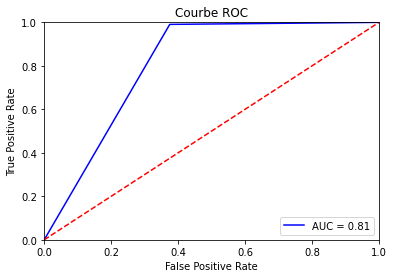

In [96]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Courbe ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
#Validation des hyperparamètres
# defining parameter range
LR = LogisticRegression()
LRparam_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': list(range(100,800,100)),
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}
LR_search = GridSearchCV(LR, param_grid=LRparam_grid, refit = True, verbose = 3, cv=5)

# fitting the model for grid search 
LR_search.fit(X_val , y_val)

In [99]:
# print best parameter after tuning 
print(LR_search.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(LR_search.best_estimator_)


{'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
LogisticRegression(C=1, solver='liblinear')


In [107]:
#Matrice de confusion avec Best Param
y_pred = LR_search.predict(X_test)
score = LR_search.score(X_test, y_test)
cm = confusion_matrix(y_test, y_pred)
print(cm, 'score: ', score)

[[ 10   6]
 [  1 106]] score:  0.943089430894309


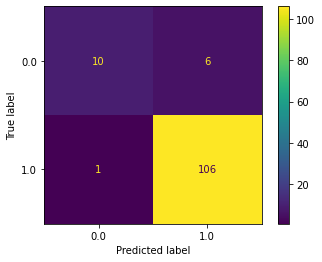

In [129]:
#Matrice de confusion du modèle avec best parameter
model_best_estimator = LogisticRegression(C=1, solver='liblinear')
model_best_estimator.fit(X_train, y_train) 
plot_confusion_matrix(model_best_estimator, X_test, y_test)
plt.show()

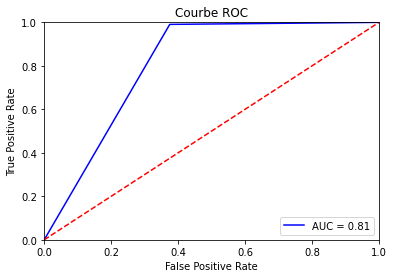

In [108]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Courbe ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 3) Modèle svm (made by Gora)

In [29]:
#creation du modèle SVM a partir de la répartition de donnée préalable
model = SVC() 
model.fit(X_train, y_train) 

SVC()

In [44]:
# print prediction results 
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

         0.0       0.91      0.62      0.74        16
         1.0       0.95      0.99      0.97       107

    accuracy                           0.94       123
   macro avg       0.93      0.81      0.85       123
weighted avg       0.94      0.94      0.94       123



In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear', 'rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_val, y_val) 

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.920, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.960, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.840, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=1.000, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] ....... C=0.1, gamma=1, kernel=linear, score=0.958, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.840, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .. C=0.1, gamma=0.0001, kernel=linear, score=0.920, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................
[CV] .. C=0.1, gamma=0.0001, kernel=linear, score=0.960, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................
[CV] .. C=0.1, gamma=0.0001, kernel=linear, score=0.840, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................
[CV] .. C=0.1, gamma=0.0001, kernel=linear, score=1.000, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=linear ..............................
[CV] .. C=0.1, gamma=0.0001, kernel=linear, score=0.958, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.840, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] ..... C=0.1, gamma=0.0001, kernel=rbf, score=0.840, total=   0.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .

[CV] ... C=10, gamma=0.0001, kernel=linear, score=0.958, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=1.000, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=0.960, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=1.000, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=1.000, total=   0.0s
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ...... C=10, gamma=0.0001, kernel=rbf, score=1.000, total=   0.0s
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] ....... C=100, gamma=1, kernel=linear, score=0.920, total=   0.0s
[CV] C=100, gamma=1, kernel=linear ...................................
[CV] .

[CV] ...... C=1000, gamma=1, kernel=linear, score=0.840, total=   0.0s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] ...... C=1000, gamma=1, kernel=linear, score=1.000, total=   0.0s
[CV] C=1000, gamma=1, kernel=linear ..................................
[CV] ...... C=1000, gamma=1, kernel=linear, score=0.958, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.840, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.840, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.800, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] ......... C=1000, gamma=1, kernel=rbf, score=0.833, total=   0.0s
[CV] C=1000, gamma=1, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.8s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             verbose=3)

In [47]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=10, gamma=0.0001)


In [79]:
model_best_estimator = SVC(C=10, gamma=0.0001)
model_best_estimator.fit(X_train, y_train) 

SVC(C=10, gamma=0.0001)

In [48]:
grid_predictions = grid.predict(X_test) 

In [35]:
# print classification report 
print(classification_report(y_test, grid_predictions)) 

              precision    recall  f1-score   support

         0.0       0.79      0.69      0.73        16
         1.0       0.95      0.97      0.96       107

    accuracy                           0.93       123
   macro avg       0.87      0.83      0.85       123
weighted avg       0.93      0.93      0.93       123



In [84]:
from sklearn.metrics import precision_score

In [88]:
#Affichage des scores de précision avec modèle par défaut
precision_score(y_test, predictions)

0.9464285714285714

In [89]:
#Affichage des scores de précision avec modèle proposé par le best param

precision_score(y_test, grid_predictions)

0.9541284403669725

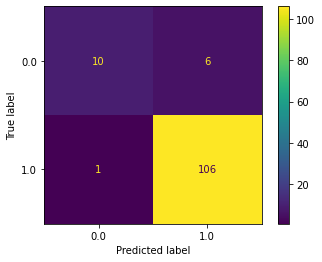

In [77]:
from sklearn.metrics import plot_confusion_matrix
#Affichage graphique de la matrice de confusion avec les paramétres par défaut
plot_confusion_matrix(model, X_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

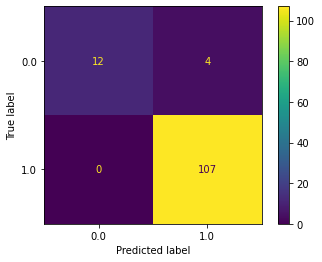

In [80]:
#Matrice de confusion du modèle avec best parameter
plot_confusion_matrix(model_best_estimator, X_test, y_test)
plt.show()

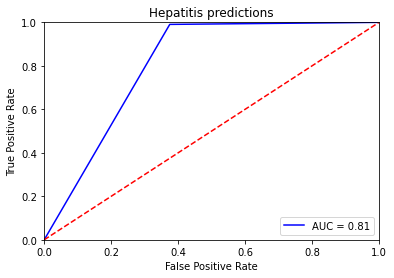

In [60]:
#Courbe ROC modèle par défaut
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.title('Hepatitis predictions')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

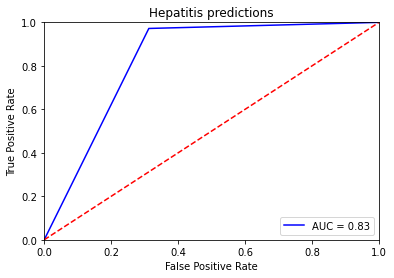

In [81]:
#Courbe ROC modèle best param
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_test, grid_predictions)
roc_auc = auc(fpr, tpr)

plt.title('Hepatitis predictions')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

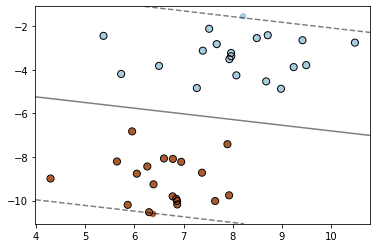

In [74]:
from sklearn import svm
from sklearn.datasets import make_blobs


# we create 40 separable points
X, y = make_blobs(n_samples=40, centers=2, random_state=6)

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(C=10, gamma=0.0001)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=50,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()